##### Imports and loading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
# import scikit-learn as sklearn
# import regex as re
from dateutil.relativedelta import relativedelta

import opendatasets
# opendatasets.download('https://www.kaggle.com/datasets/vijayuv/onlineretail')

In [2]:
data = pd.read_csv('onlineretail/OnlineRetail.csv', encoding='ISO-8859-1')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


##### Data pre-processing --> Data Cleaning

In [3]:
price_threshold = 0  # Example: remove rows with price <= 0
quantity_threshold = 0  # Example: remove rows with quantity <= 0

# Keep only rows where BOTH conditions are met
data = data[(data['UnitPrice'] > price_threshold) & (data['Quantity'] > quantity_threshold)]
# data.reset_index(inplace=True)
# data.iloc[:,:]
data.reset_index(drop=True, inplace=True)
data = data[data['InvoiceNo'] != 'A563185']
data['InvoiceNo'] = data['InvoiceNo'].astype(int) # made the InvoiceNo as int

data['TotalPrice'] = data['UnitPrice'] * data['Quantity']
data['TotalPrice'] = data['TotalPrice'].astype(float)


data['Date'] = pd.to_datetime(data['InvoiceDate'].apply(lambda x: str(x).split(' ')[0].replace('/','-')))
data['Time'] = data['InvoiceDate'].apply(lambda x: str(x).split(' ')[1])
data['Hour'] = data['Time'].apply(lambda x: int(x.split(':')[0]))
data['DayOfWeek'] = data['Date'].dt.day_name()
data['Month'] = data['Date'].dt.month_name()
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Date,Time,Hour,DayOfWeek,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,2010-12-01,8:26,8,Wednesday,December
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01,8:26,8,Wednesday,December
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,2010-12-01,8:26,8,Wednesday,December
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01,8:26,8,Wednesday,December
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01,8:26,8,Wednesday,December
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530099,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20,2011-12-09,12:50,12,Friday,December
530100,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60,2011-12-09,12:50,12,Friday,December
530101,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60,2011-12-09,12:50,12,Friday,December
530102,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60,2011-12-09,12:50,12,Friday,December


### 1. Data Overview and Quality Assessment

##### 1.1) What is the time period covered in the dataset?

In [4]:
Start_Date = pd.to_datetime(data['InvoiceDate'][0].split(' ')[0].replace('/','-'))
End_Date = pd.to_datetime(data['InvoiceDate'].iloc[-1].split(' ')[0].replace('/','-'))
# Time_Period = pd.date_range(Start_Date, End_Date, freq='ME')
# Time_Period
Time_Period = relativedelta(End_Date, Start_Date)
Time_Period_Text = f"{Time_Period.years} years, {Time_Period.months} months, {Time_Period.days} days"
Time_Period_Text

'1 years, 0 months, 8 days'

##### 1.2) How many unique transactions, customers, and products are there?

In [5]:
unique_customers = data['CustomerID'].nunique()
unique_transactions = data['InvoiceNo'].nunique()
unique_products = data['Description'].nunique()
unique_country = data['Country'].unique()
unique_country

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Bahrain', 'Israel', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

##### 1.3) Are there any data quality issues (missing values, duplicates, outliers)?"

In [6]:

# duplicates--> 
duplicates = data.duplicated().sum()
duplicates

# outliers-->
# Outliers can be detected using the IQR method
Q1 = data['UnitPrice'].quantile(0.25)
Q3 = data['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['UnitPrice'] < lower_bound) | (data['UnitPrice'] > upper_bound)]
outliers_count = outliers.shape[0]
outliers_count

37998

##### 1.4) Are there any unusual patterns in the data (negative quantities, zero prices)?

In [7]:
negative_quantities = len(data) - len(data[data['Quantity'] > 0])
data['Quantity'] = data['Quantity'].replace(0, np.nan)
zero_prices = data[data['UnitPrice'] <= 0]
len(zero_prices)

0

##### 1.5) Create a choropleth map for sales distribution by country

In [49]:
country_sales = data.groupby(['Country'])['TotalPrice'].sum().reset_index()

# Create a choropleth map
fig = px.choropleth(country_sales, 
                   locations='Country',
                   locationmode='country names',
                   color='TotalPrice',
                   hover_name='Country',
                   title='Total Sales by Country',
                   color_continuous_scale=px.colors.sequential.Plasma,
                   projection='natural earth')

fig.update_layout(
    coloraxis_colorbar=dict(
        title='Total Sales (£)'
    ),
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),
    height=600,
    width=1000
)

fig.show()

# Create a treemap for hierarchical view of sales by country
fig_treemap = px.treemap(country_sales, 
                         path=['Country'], 
                         values='TotalPrice',
                         color='TotalPrice',
                         color_continuous_scale='RdBu',
                         title='Sales Distribution Across Countries (Treemap)')
fig_treemap.update_layout(height=600, width=900)
fig_treemap.show()

### 2. Customer Behavior Analysis

##### 2.1) How are sales distributed across different countries?

In [9]:
a = data.groupby(['Country'])['InvoiceNo'].sum()
a

Country
Australia                  657415628
Austria                    223822318
Bahrain                      9936937
Belgium                   1138462862
Brazil                      17606432
Canada                      84252636
Channel Islands            417972473
Cyprus                     341888568
Czech Republic              13876340
Denmark                    213742248
EIRE                      4429345799
European Community          33434869
Finland                    382635802
France                    4714753052
Germany                   5061018356
Greece                      80713029
Hong Kong                  157626844
Iceland                    101296926
Israel                     165712058
Italy                      425518649
Japan                      176939004
Lebanon                     24402420
Lithuania                   18798630
Malta                       62931641
Netherlands               1318829653
Norway                     603201625
Poland                     184

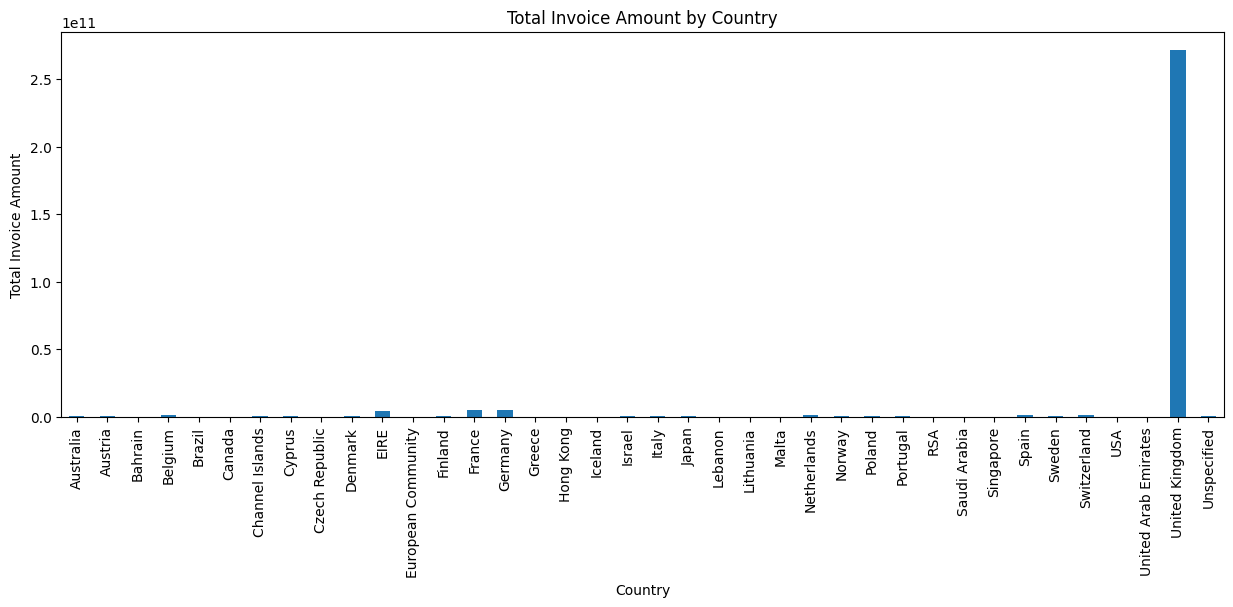

In [10]:
a.plot(kind='bar', figsize=(15, 5))
plt.title('Total Invoice Amount by Country')
plt.xlabel('Country')
plt.ylabel('Total Invoice Amount')
plt.xticks(rotation=90)
plt.show()

##### 2.2) What is the distribution of order sizes (number of items per transaction)?

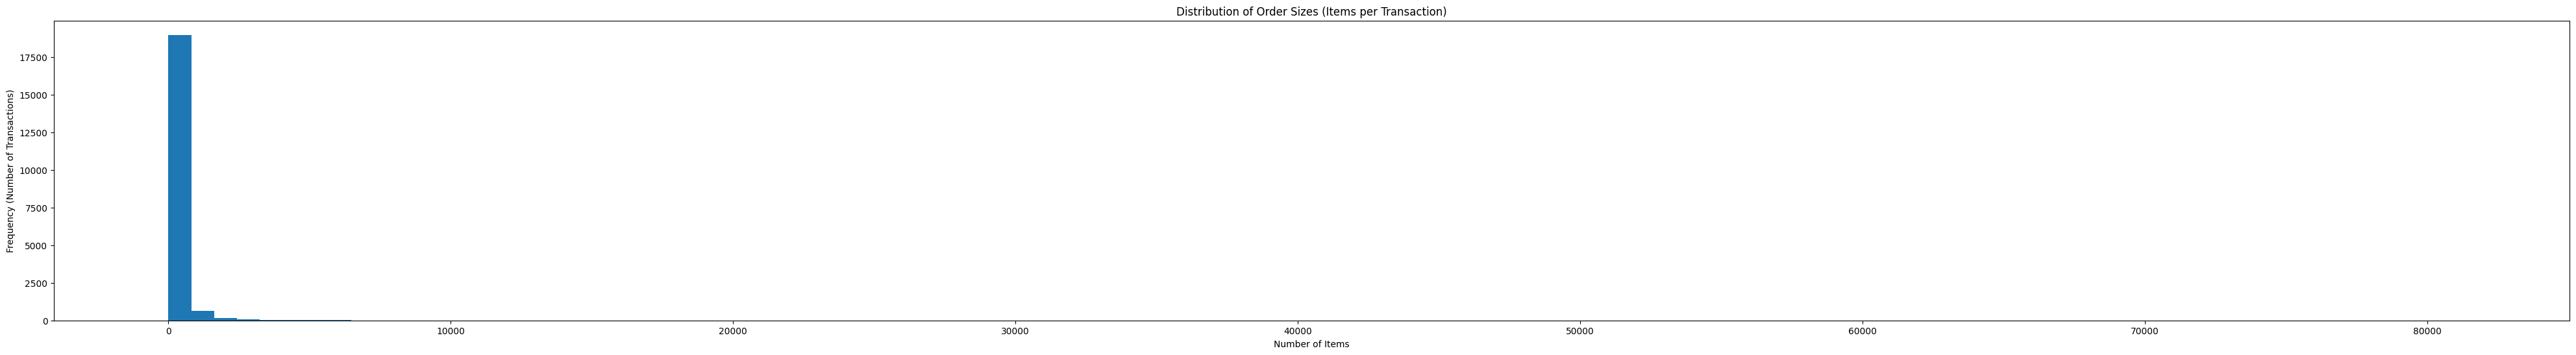

In [11]:
data.groupby('InvoiceNo')['Quantity'].sum().plot(kind='hist', bins=100, figsize=(50, 6))
plt.title('Distribution of Order Sizes (Items per Transaction)')
plt.xlabel('Number of Items')
plt.ylabel('Frequency (Number of Transactions)')


# Create violin plot for distribution of order sizes
items_per_transaction = data.groupby('InvoiceNo')['Quantity'].sum().reset_index()

fig = px.violin(items_per_transaction, y='Quantity', box=True, points='all',
                title='Distribution of Order Sizes (Items per Transaction)',
                labels={'Quantity': 'Number of Items'},
                height=600)

fig.update_traces(
    points='all', pointpos=-0.5, jitter=0.3, 
    marker=dict(size=3, opacity=0.6)
)
fig.update_layout(
    violinmode='overlay',
    xaxis_title='',
    yaxis_title='Number of Items per Transaction',
    showlegend=False
)

# Add a secondary axis for log scale to better visualize the distribution
fig.update_layout(
    yaxis2=dict(
        title='Log Scale',
        overlaying='y',
        side='right',
        type='log'
    )
)

fig.show()

##### 2.3) What is the typical basket value (total transaction amount)?

Text(0.5, 1.0, 'Distribution of Order Values (Total Price per Transaction)')

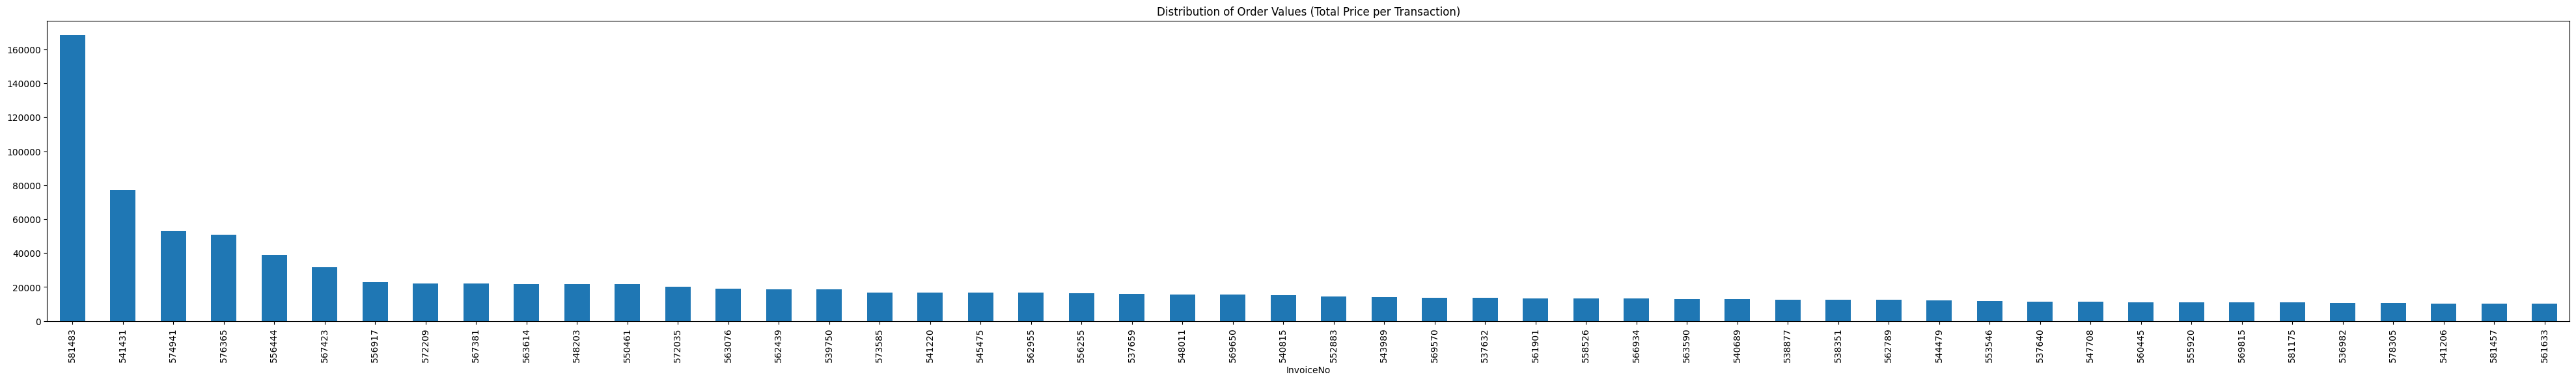

In [12]:
data.groupby('InvoiceNo')['TotalPrice'].sum().sort_values(ascending=False).head(50).plot(kind='bar', figsize=(50, 6))
plt.title('Distribution of Order Values (Total Price per Transaction)')

##### 2.4) Are there seasonal patterns in purchasing behavior?

Text(0.5, 1.0, 'Total Sales by Season')

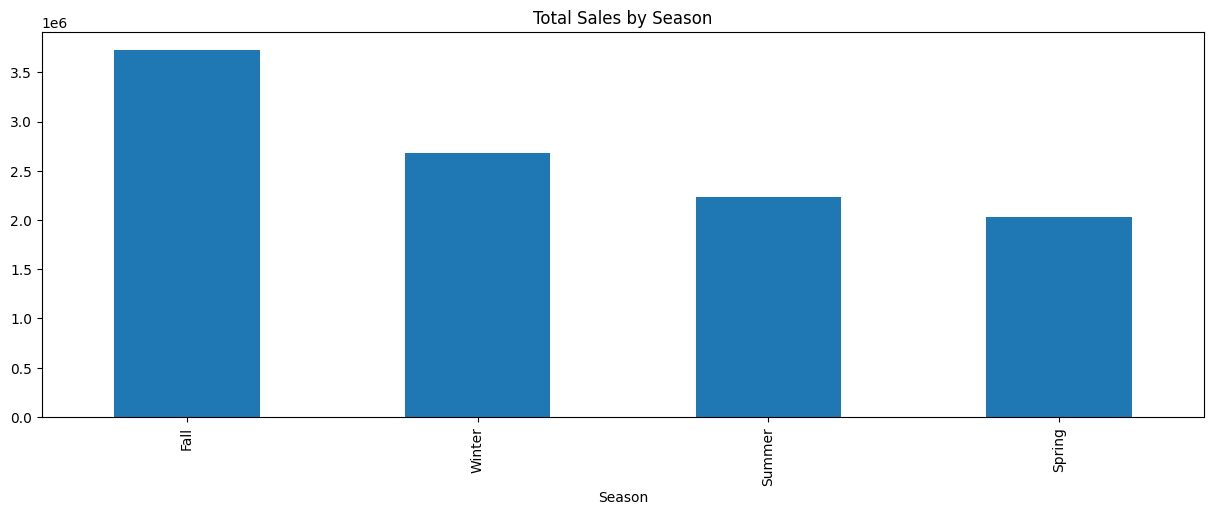

In [13]:
# first define seasons based on invoice date
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
# apply the function to create a new column
data['Season'] = pd.to_datetime(data['InvoiceDate']).apply(get_season)
# group by season and sum the total price
seasonal_sales = data.groupby('Season')['TotalPrice'].sum().sort_values(ascending=False)
seasonal_sales.plot(kind='bar', figsize=(15, 5))
plt.title('Total Sales by Season')

##### 2.5) creating a sunbrust chart to visualize the distribution of sales by country and month

In [14]:
# another visualization
# Create a sunburst chart for seasonal breakdown
seasonal_data = data.groupby(['Season', 'Month'])['TotalPrice'].sum().reset_index()

fig = px.sunburst(
    seasonal_data,
    path=['Season', 'Month'],
    values='TotalPrice',
    title='Sales Breakdown by Season and Month',
    color='TotalPrice',
    color_continuous_scale='Viridis'
)

fig.update_layout(height=700, width=700)
fig.show()

# Create a radar chart for seasonal patterns
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_sales = data.groupby('Season')['TotalPrice'].sum()
seasonal_count = data.groupby('Season').size()

# Create radar chart for sales by season
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=seasonal_sales.reindex(seasons).values,
    theta=seasons,
    fill='toself',
    name='Total Sales'
))

fig.add_trace(go.Scatterpolar(
    r=seasonal_count.reindex(seasons).values/max(seasonal_count)*max(seasonal_sales),  # Normalize
    theta=seasons,
    fill='toself',
    name='Transaction Count (Normalized)'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(seasonal_sales)*1.1]
        )),
    showlegend=True,
    title='Seasonal Sales and Transaction Patterns'
)

fig.show()

### 3. Product Analysis

##### 3.1) What are the most frequently purchased products?

In [29]:
data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(20)

Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        78033
WORLD WAR 2 GLIDERS ASSTD DESIGNS     55047
JUMBO BAG RED RETROSPOT               48474
WHITE HANGING HEART T-LIGHT HOLDER    37891
POPCORN HOLDER                        36761
ASSORTED COLOUR BIRD ORNAMENT         36461
PACK OF 72 RETROSPOT CAKE CASES       36419
RABBIT NIGHT LIGHT                    30788
MINI PAINT SET VINTAGE                26633
PACK OF 12 LONDON TISSUES             26135
PACK OF 60 PINK PAISLEY CAKE CASES    24854
VICTORIAN GLASS HANGING T-LIGHT       24304
ASSORTED COLOURS SILK FAN             23826
BROCADE RING PURSE                    23056
RED  HARMONICA IN BOX                 21933
JUMBO BAG PINK POLKADOT               21465
SMALL POPCORN HOLDER                  20160
PAPER CHAIN KIT 50'S CHRISTMAS        19355
LUNCH BAG RED RETROSPOT               19353
Name: Quantity, dtype: int64

##### 3.2) Top products sold by Quantity and Revenue

In [30]:
# Top 20 products by quantity sold - using bar chart with Plotly
top_products = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(20).reset_index()

fig = px.bar(top_products, 
             x='Description', 
             y='Quantity',
             title='Top 20 Products by Quantity Sold',
             color='Quantity',
             color_continuous_scale=px.colors.sequential.Plasma)

fig.update_layout(
    xaxis={'categoryorder':'total descending', 'tickangle': 45},  # Include tickangle in update_layout
    xaxis_title='Product',
    yaxis_title='Quantity Sold',
    height=600,
    width=1000
)

# Remove the separate update_xaxis call that's causing the error
# fig.update_xaxis(tickangle=45)  # This line should be removed

fig.show()

# Top products by revenue - using treemap for hierarchical representation
top_revenue = data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(20).reset_index()

fig = px.treemap(
    top_revenue,
    path=['Description'],
    values='TotalPrice',
    title='Top 20 Products by Revenue',
    color='TotalPrice',
    color_continuous_scale='Blues'
)

fig.update_layout(height=700, width=1000)
fig.show()

##### 3.3) What are the highest revenue-generating products?

<Axes: xlabel='Description'>

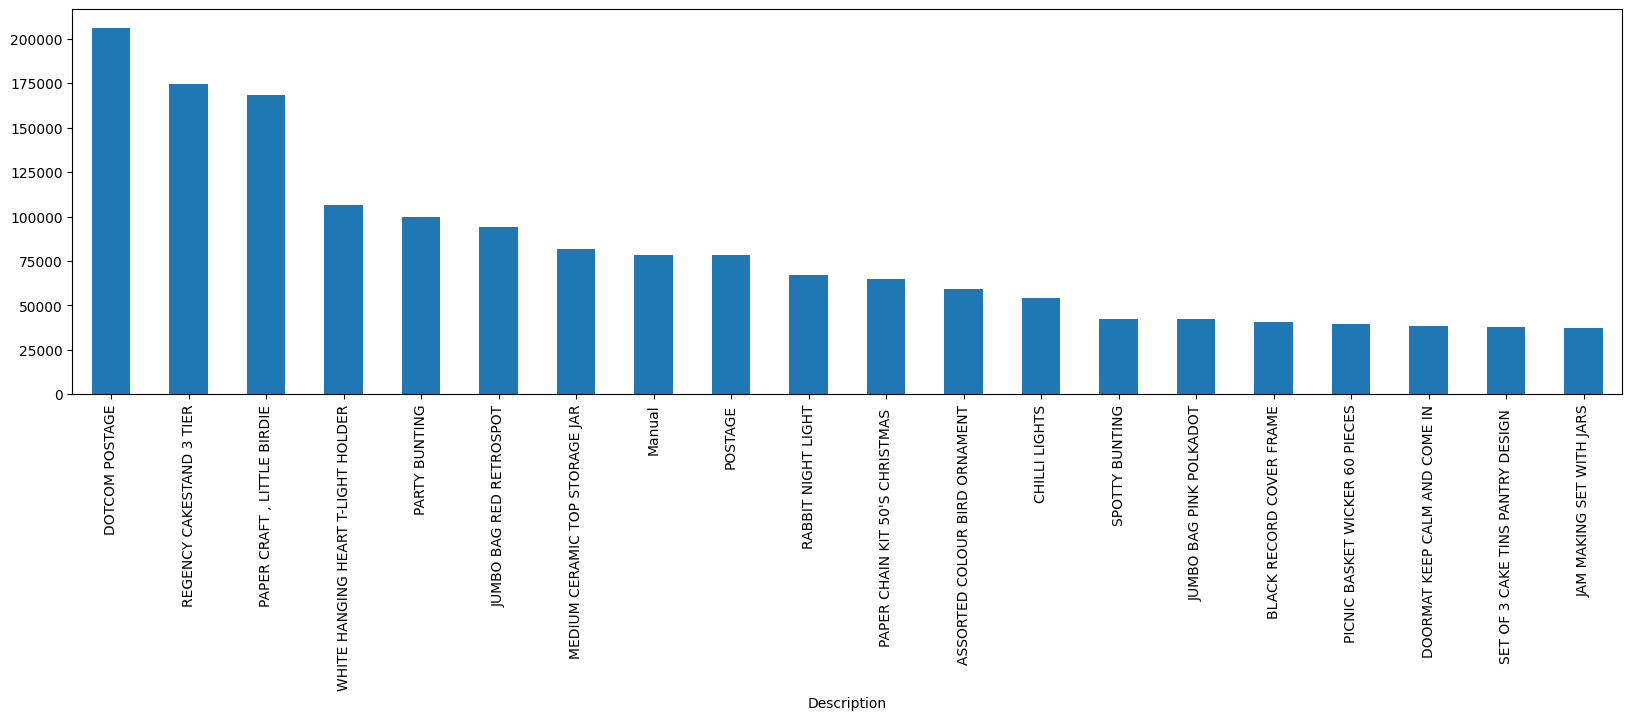

In [31]:
data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(20, 5))

##### 3.4) How diverse is the product catalog and how are sales distributed across it?

<Axes: xlabel='Description'>

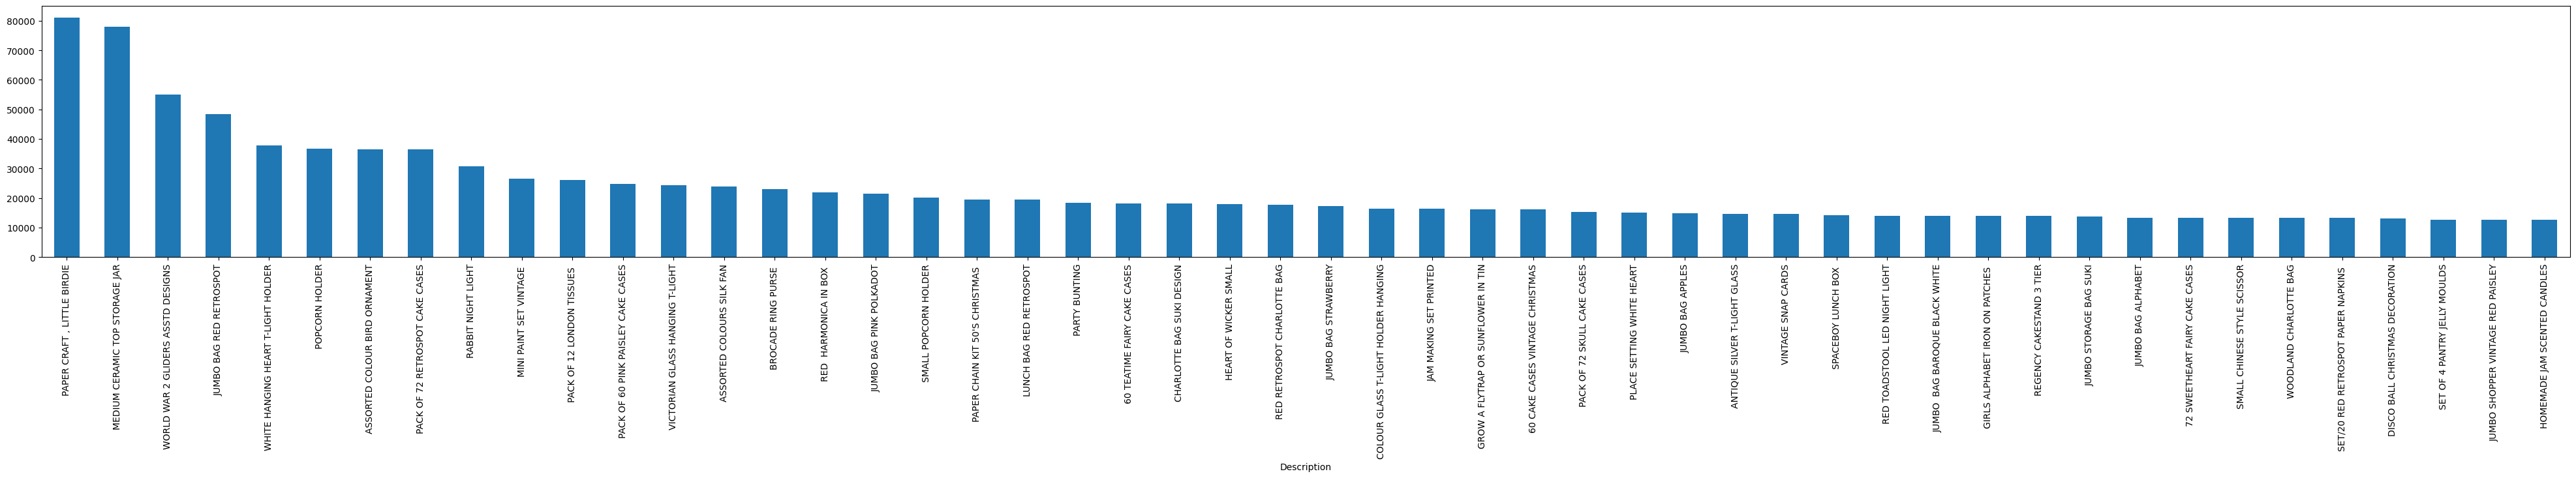

In [32]:
data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(50).plot(kind = 'bar', figsize=(50, 5))

##### 3.5) Transactional Value Dristribution

In [ ]:
# Calculate transaction totals
transaction_totals = data.groupby('InvoiceNo')['TotalPrice'].sum().reset_index()

# Create a histogram with Plotly
fig = px.histogram(transaction_totals, 
                   x='TotalPrice', 
                   title='Distribution of Transaction Values',
                   labels={'TotalPrice': 'Transaction Value (£)'},
                   nbins=50,
                   marginal='box',  # Add a box plot on the margin
                   color_discrete_sequence=['darkblue'])

fig.update_layout(
    bargap=0.1,
    xaxis_title='Transaction Value (£)',
    yaxis_title='Frequency',
    height=600,
    width=1000
)

# Add 95th percentile line
percentile_95 = transaction_totals['TotalPrice'].quantile(0.95)
fig.add_vline(x=percentile_95, line_dash="dash", line_color="red",
              annotation_text=f"95th Percentile: £{percentile_95:.2f}",
              annotation_position="top right")

fig.show()

##### 3.6) Are there product categories or natural groupings that emerge?

In [ ]:
# can't answer this right now.

### 4. Transaction Patterns

##### 4.1) What is the distribution of transaction times/days?

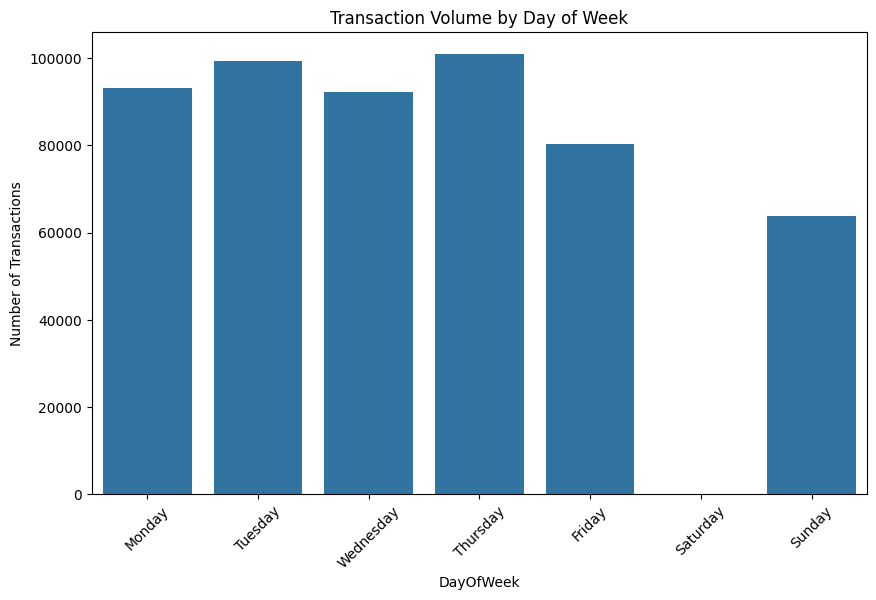

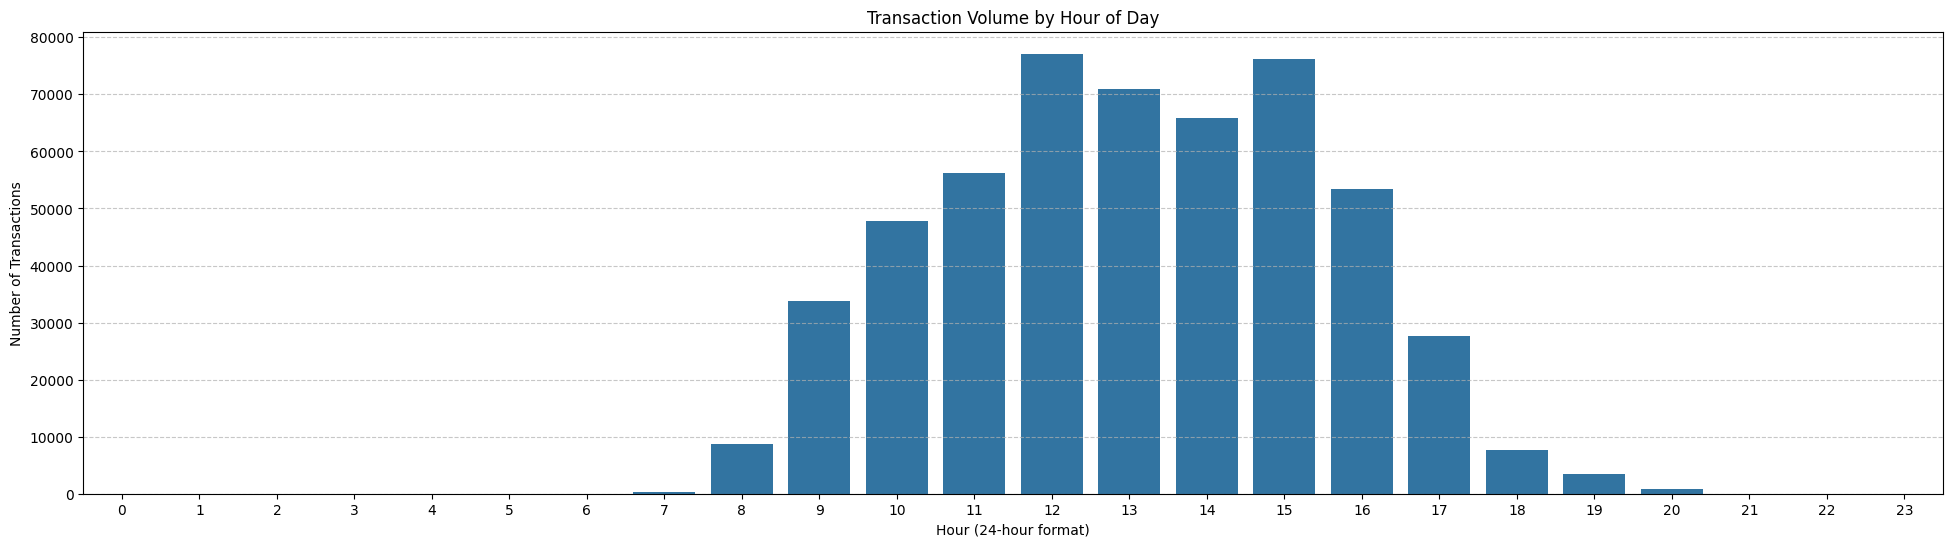

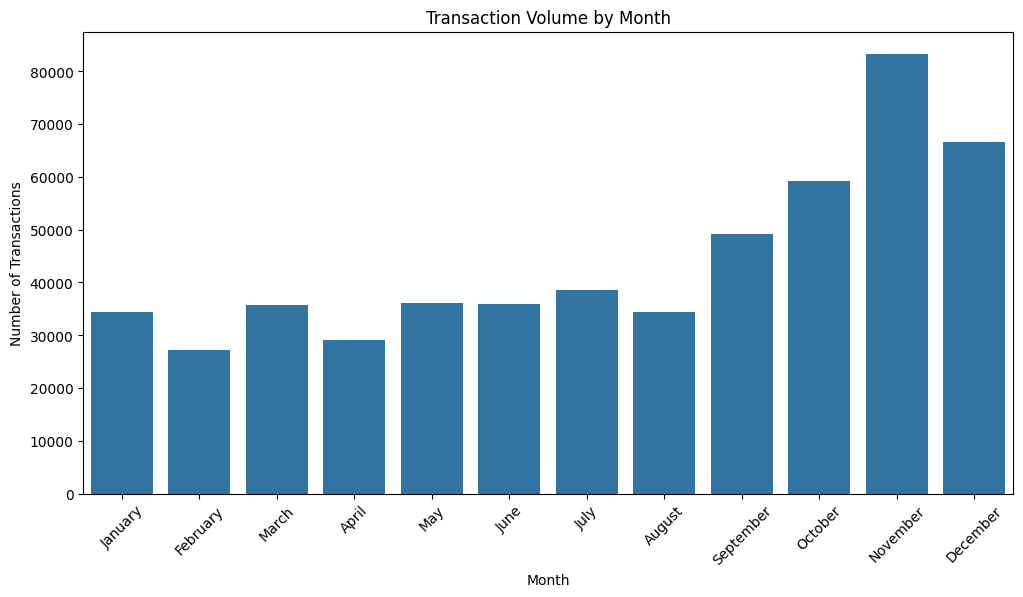

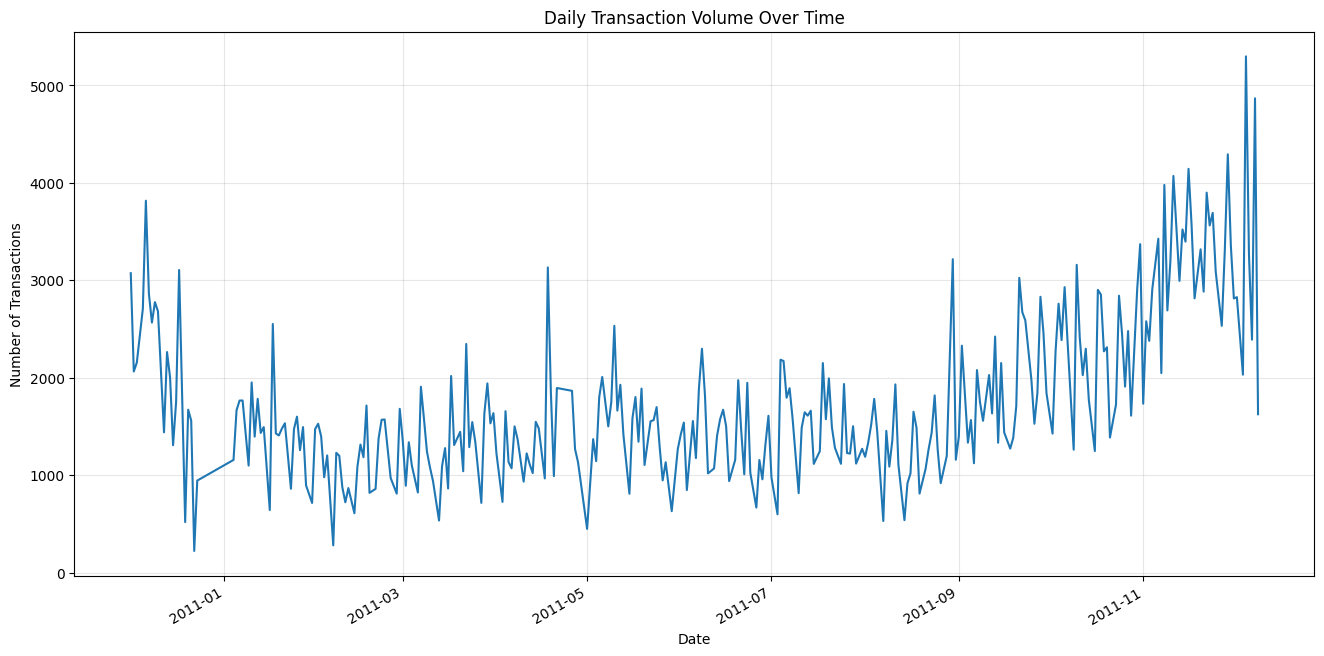

In [21]:
# find --> Day of the week, Time of the day, monthly patterns, visualization
data['Date'] = pd.to_datetime(data['InvoiceDate'].apply(lambda x: str(x).split(' ')[0].replace('/','-')))
data['Time'] = data['InvoiceDate'].apply(lambda x: str(x).split(' ')[1])
data['Hour'] = data['Time'].apply(lambda x: int(x.split(':')[0]))
data['DayOfWeek'] = data['Date'].dt.day_name()
data['Month'] = data['Date'].dt.month_name()

# ------------------------------------------------------------------------------------------------------------------------------------ #

# 1. Day of Week Distribution
plt.figure(figsize=(10, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = data['DayOfWeek'].value_counts().reindex(day_order)
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Transaction Volume by Day of Week')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

# ------------------------------------------------------------------------------------------------------------------------------------ #

# 2. Hour of Day Distribution
plt.figure(figsize=(24, 6))
all_hours = pd.Series(range(24))
hour_counts = data['Hour'].value_counts().sort_index()
hour_counts = hour_counts.reindex(all_hours, fill_value=0)
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Transaction Volume by Hour of Day')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Transactions') 
plt.xticks(range(24))  # Explicitly mark all 24 hours
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ------------------------------------------------------------------------------------------------------------------------------------ #

# 3. Monthly Distribution
plt.figure(figsize=(12, 6))
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_counts = data['Month'].value_counts().reindex(month_order)
sns.barplot(x=month_counts.index, y=month_counts.values)
plt.title('Transaction Volume by Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

# ------------------------------------------------------------------------------------------------------------------------------------ #

# 4. Calendar Heatmap (daily transactions)
daily_counts = data.groupby('Date').size()
plt.figure(figsize=(16, 8))
daily_counts.plot()
plt.title('Daily Transaction Volume Over Time')
plt.ylabel('Number of Transactions')
plt.grid(True, alpha=0.3)
plt.show()
# data

##### 4.2) Transaction pattern by Day/Time

In [22]:
# Create a heatmap for hourly patterns by day using Plotly
hourly_patterns = data.groupby(['DayOfWeek', 'Hour'])['TotalPrice'].sum().unstack(level=0)

# Ensure all days are in correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_patterns = hourly_patterns.reindex(columns=day_order)

fig = go.Figure(data=go.Heatmap(
                z=hourly_patterns.values,
                x=hourly_patterns.columns,
                y=hourly_patterns.index,
                colorscale='Viridis',
                text=hourly_patterns.values,
                texttemplate='%{text:.1f}',
                textfont={"size": 10}))

fig.update_layout(
    title='Hourly Sales Patterns by Day of Week',
    xaxis_title='Day of Week',
    yaxis_title='Hour of Day',
    height=800,
    width=1000
)

fig.show()

# Create a bubble chart for transaction volume by day and hour
day_hour_data = data.groupby(['DayOfWeek', 'Hour']).agg(
    transaction_count=('InvoiceNo', 'nunique'),
    total_sales=('TotalPrice', 'sum')
).reset_index()

# Mapping days to numeric values for better visualization
day_map = {day: i for i, day in enumerate(day_order)}
day_hour_data['day_numeric'] = day_hour_data['DayOfWeek'].map(day_map)

fig = px.scatter(
    day_hour_data,
    x='Hour', 
    y='day_numeric',
    size='transaction_count',
    color='total_sales',
    hover_name='DayOfWeek',
    labels={'day_numeric': 'Day of Week'},
    title='Transaction Volume and Sales by Hour and Day',
    color_continuous_scale='Viridis',
    size_max=40,
    height=600
)

fig.update_yaxes(
    tickvals=list(day_map.values()),
    ticktext=list(day_map.keys())
)

fig.update_layout(
    xaxis_title='Hour of Day',
    yaxis_title='Day of Week',
    coloraxis_colorbar=dict(title='Total Sales (£)')
)

fig.show()

##### 4.3) How do transaction patterns vary by country or customer segment?

###### For Country-based Analysis:

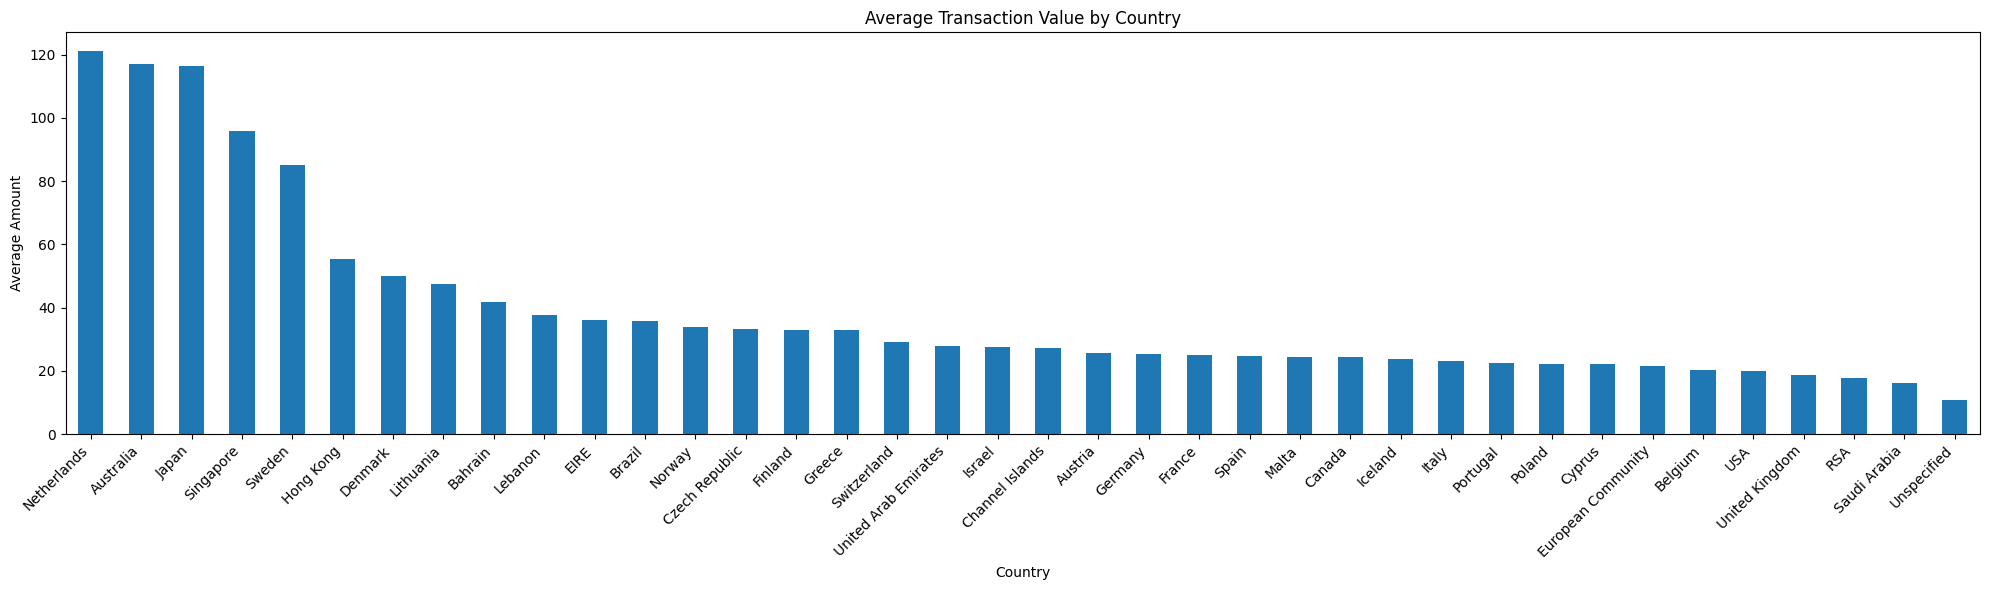

In [23]:
# Bar charts with grouped data:
country_avg = data.groupby('Country')['TotalPrice'].mean().sort_values(ascending=False)
country_avg.plot(kind='bar', figsize=(20, 6))
plt.title('Average Transaction Value by Country')
plt.ylabel('Average Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Box plots for transaction value distribution:


##### 4.4) Are there identifiable shopping peaks or patterns during the week/month?

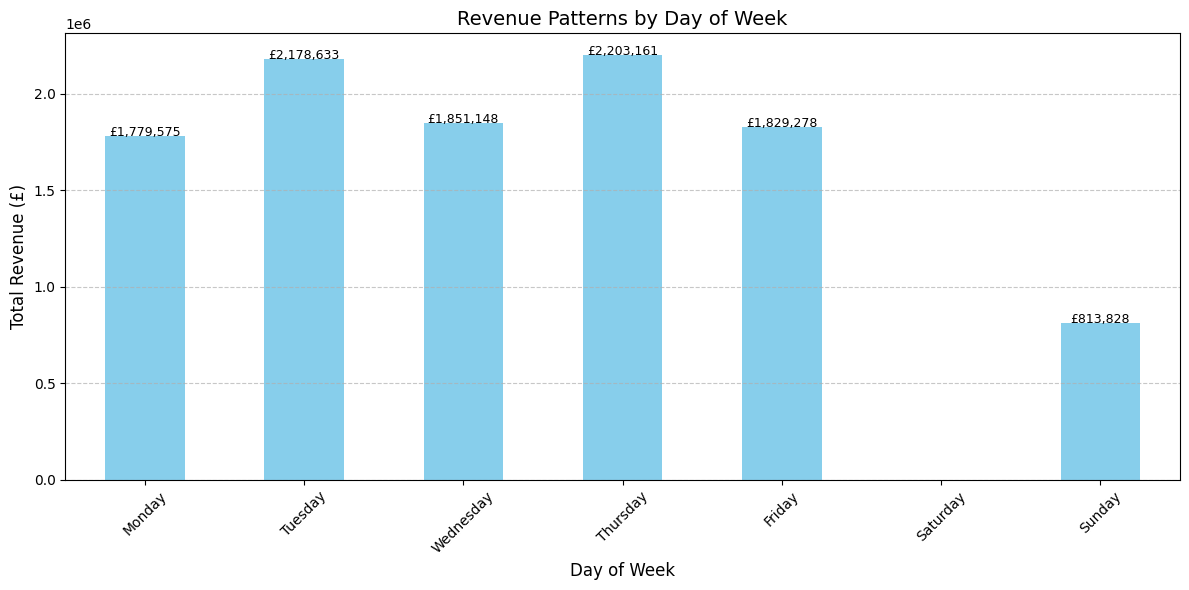


Revenue by Day of Week:
Monday: £1,779,575.04
Tuesday: £2,178,632.61
Wednesday: £1,851,147.81
Thursday: £2,203,161.24
Friday: £1,829,278.17
Saturday: £nan
Sunday: £813,827.61


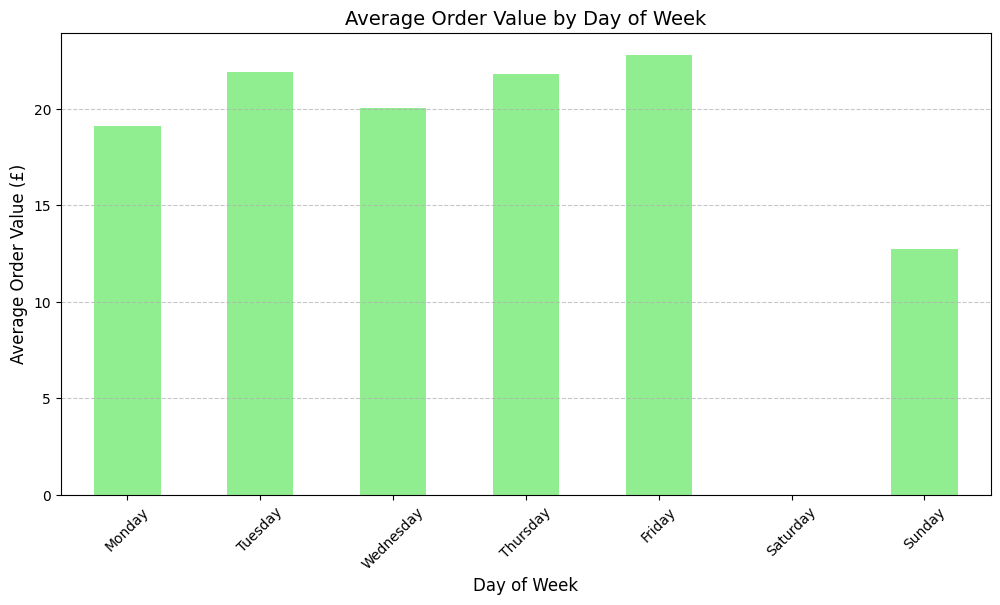

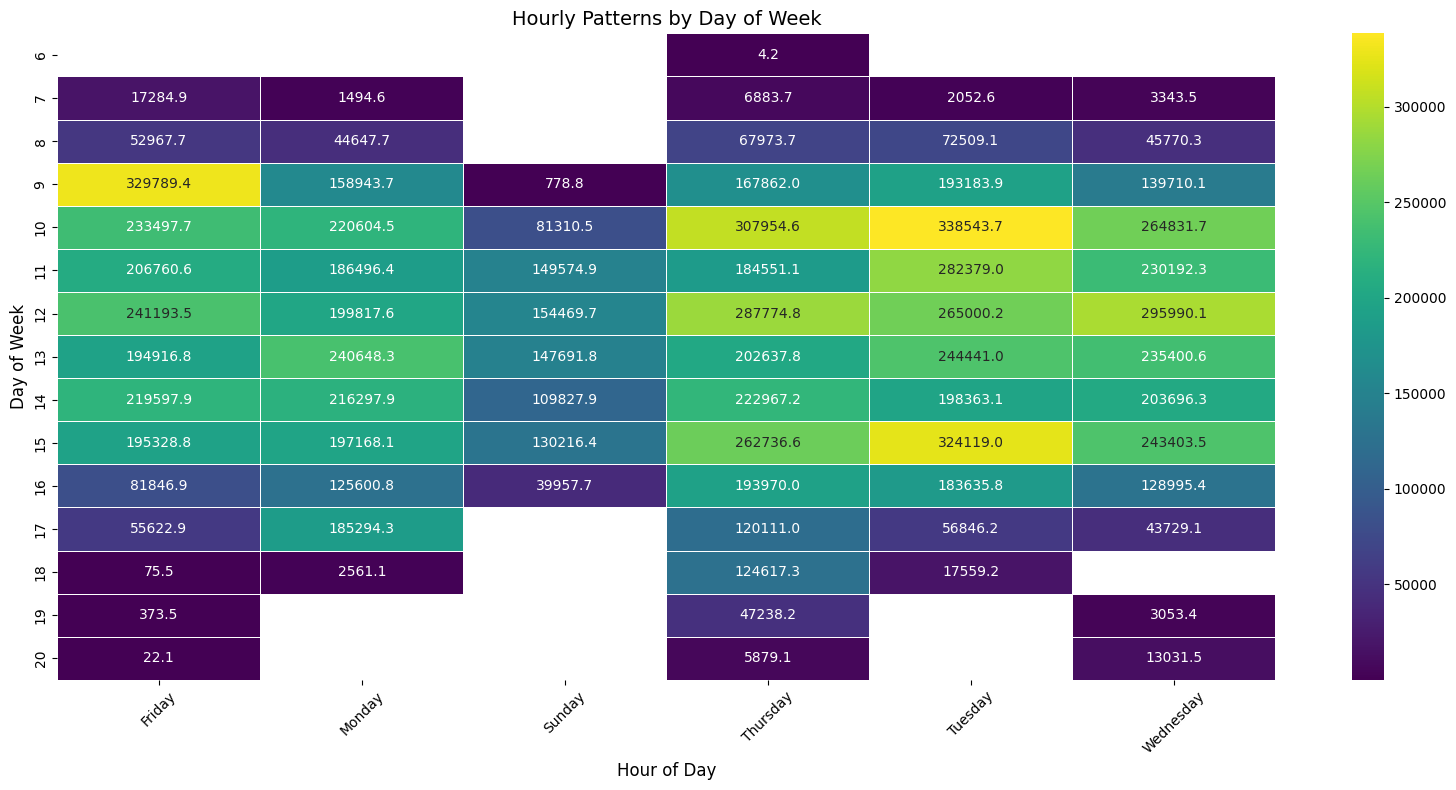

In [24]:
# during week

# data['DayOfWeek'].unique().sum()
# day_counts = data['DayOfWeek'].value_counts().sort_values(ascending=False) # we can see that there are 6 days present in the dataset, excluding Saturday. maybe market is closed on Saturday.
# day_counts.plot(kind='bar', figsize=(10, 6))
# plt.xticks(rotation=45, ha='right')

# ------------------------------------------------------------------------------------------------------------------------------------ #

# 1. **Revenue patterns by day of week** - This will show if certain days generate more sales, even if they don't have the most transactions
# Define the correct order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day of week and sum total price
revenue_by_day = data.groupby('DayOfWeek')['TotalPrice'].sum().reindex(day_order)

# Create a visualization
plt.figure(figsize=(12, 6))
ax = revenue_by_day.plot(kind='bar', color='skyblue')
plt.title('Revenue Patterns by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Revenue (£)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(revenue_by_day):
    ax.text(i, v + 0.1, f'£{v:,.0f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print the summary for additional insights
print("\nRevenue by Day of Week:")
for day, revenue in revenue_by_day.items():
    print(f"{day}: £{revenue:,.2f}")

# ------------------------------------------------------------------------------------------------------------------------------------ #

# 2. **Average order value by day** - This indicates whether customers spend more per transaction on specific days
avg_order_value_by_day = data.groupby('DayOfWeek')['TotalPrice'].mean().reindex(day_order)
plt.figure(figsize=(12, 6))
ax = avg_order_value_by_day.plot(kind='bar', color='lightgreen')
plt.title('Average Order Value by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Order Value (£)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# ------------------------------------------------------------------------------------------------------------------------------------ #

# 3. **Hourly patterns by day** - To identify peak shopping hours for each day of the week

hourly_patterns = data.groupby(['DayOfWeek', 'Hour'])['TotalPrice'].sum().unstack(level=0)
plt.figure(figsize=(16, 8))
sns.heatmap(hourly_patterns, cmap='viridis', annot=True, fmt=".1f", linewidths=.5)
plt.title('Hourly Patterns by Day of Week', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### 4.5) Seasonal Patterns

In [25]:
# Create a sunburst chart for seasonal breakdown
seasonal_data = data.groupby(['Season', 'Month'])['TotalPrice'].sum().reset_index()

fig = px.sunburst(
    seasonal_data,
    path=['Season', 'Month'],
    values='TotalPrice',
    title='Sales Breakdown by Season and Month',
    color='TotalPrice',
    color_continuous_scale='Viridis'
)

fig.update_layout(height=700, width=700)
fig.show()

# Create a radar chart for seasonal patterns
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_sales = data.groupby('Season')['TotalPrice'].sum()
seasonal_count = data.groupby('Season').size()

# Create radar chart for sales by season
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=seasonal_sales.reindex(seasons).values,
    theta=seasons,
    fill='toself',
    name='Total Sales'
))

fig.add_trace(go.Scatterpolar(
    r=seasonal_count.reindex(seasons).values/max(seasonal_count)*max(seasonal_sales),  # Normalize
    theta=seasons,
    fill='toself',
    name='Transaction Count (Normalized)'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(seasonal_sales)*1.1]
        )),
    showlegend=True,
    title='Seasonal Sales and Transaction Patterns'
)

fig.show()

### 5. Association Analysis

##### 5.1) What are the strongest product associations based on support, confidence, and lift metrics?

In [37]:
# SELF-CONTAINED NETWORK GRAPH VISUALIZATION
# This cell contains all code needed to create the product association network

# Step 1: Group products by invoice number
invoice_items = data.groupby('InvoiceNo')['Description'].apply(list).reset_index()

# Step 2: Initialize counter for product pairs
product_pairs = Counter()

# Step 3: Generate all possible pairs of products for each transaction
for items in invoice_items['Description']:
    # Only consider transactions with at least 2 items
    if len(items) >= 2:
        # Generate all possible pairs from the items in this transaction
        for pair in combinations(sorted(set(items)), 2):
            product_pairs[pair] += 1

# Step 4: Calculate total number of transactions
total_transactions = len(invoice_items)

# Step 5: Create dictionaries to store item frequencies
item_frequencies = {}
for items in invoice_items['Description']:
    for item in set(items):  # Count each item once per transaction
        item_frequencies[item] = item_frequencies.get(item, 0) + 1

# Step 6: Create DataFrame to store association metrics
association_metrics = []

# Calculate metrics for most common pairs
for pair, count in product_pairs.most_common(50):  # Analyze top 50 pairs
    item_a, item_b = pair
    support = count / total_transactions
    confidence_a_to_b = count / item_frequencies[item_a]
    confidence_b_to_a = count / item_frequencies[item_b]
    lift = (count * total_transactions) / (item_frequencies[item_a] * item_frequencies[item_b])
    
    association_metrics.append({
        'Item A': item_a,
        'Item B': item_b,
        'Support': support,
        'Confidence (A→B)': confidence_a_to_b,
        'Confidence (B→A)': confidence_b_to_a,
        'Lift': lift,
        'Count': count
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(association_metrics)

# Step 7: Create network graph of product associations
G = nx.Graph()

# Add nodes for top products
for product in item_frequencies:
    if item_frequencies[product] > 300:  # Only add significant products
        G.add_node(product, size=item_frequencies[product])

# Add edges for product associations with significant lift
for _, row in metrics_df.iterrows():
    if row['Lift'] > 1.5 and row['Support'] > 0.01:
        G.add_edge(row['Item A'], row['Item B'], 
                 weight=row['Lift'], 
                 confidence=row['Confidence (A→B)'])

# Get node positions
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Create edge trace
edge_x = []
edge_y = []
edge_text = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    
    lift = G.edges[edge]['weight']
    confidence = G.edges[edge]['confidence']
    edge_text.append(f"Lift: {lift:.2f}, Confidence: {confidence:.2f}")

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.8, color='gray'),
    hoverinfo='text',
    text=edge_text,
    mode='lines')

# Create node trace
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_sizes = [G.nodes[node]['size']/50 for node in G.nodes()]
node_text = [f"{node}<br>Frequency: {G.nodes[node]['size']}" for node in G.nodes()]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=node_text,
    textposition='top center',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=node_sizes,
        colorbar=dict(
            thickness=15,
            title='Frequency',
            xanchor='left',
            title_side='right'
        ),
        line_width=2))

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=dict(
        text='Product Association Network',
        font=dict(size=16)
    ),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                height=800,
                width=900
            ))

fig.show()

##### 5.2) Are there interesting product combinations that might inform store layout or marketing?


Top Product Combinations for Store Layout Planning:
GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER : Lift = 14.19, Support = 0.0384
GREEN REGENCY TEACUP AND SAUCER + PINK REGENCY TEACUP AND SAUCER: Lift = 16.28, Support = 0.0317
PINK REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER : Lift = 14.65, Support = 0.0300
GARDENERS KNEELING PAD CUP OF TEA  + GARDENERS KNEELING PAD KEEP CALM : Lift = 15.75, Support = 0.0274
ALARM CLOCK BAKELIKE GREEN + ALARM CLOCK BAKELIKE RED : Lift = 12.40, Support = 0.0321
DOLLY GIRL LUNCH BOX + SPACEBOY LUNCH BOX : Lift = 14.04, Support = 0.0270
CHARLOTTE BAG PINK POLKADOT + RED RETROSPOT CHARLOTTE BAG: Lift = 13.61, Support = 0.0262
PAPER CHAIN KIT 50'S CHRISTMAS  + PAPER CHAIN KIT VINTAGE CHRISTMAS: Lift = 11.58, Support = 0.0277
RED RETROSPOT CHARLOTTE BAG + STRAWBERRY CHARLOTTE BAG: Lift = 13.02, Support = 0.0243
RED RETROSPOT CHARLOTTE BAG + WOODLAND CHARLOTTE BAG: Lift = 11.72, Support = 0.0253
CHARLOTTE BAG SUKI DESIGN 

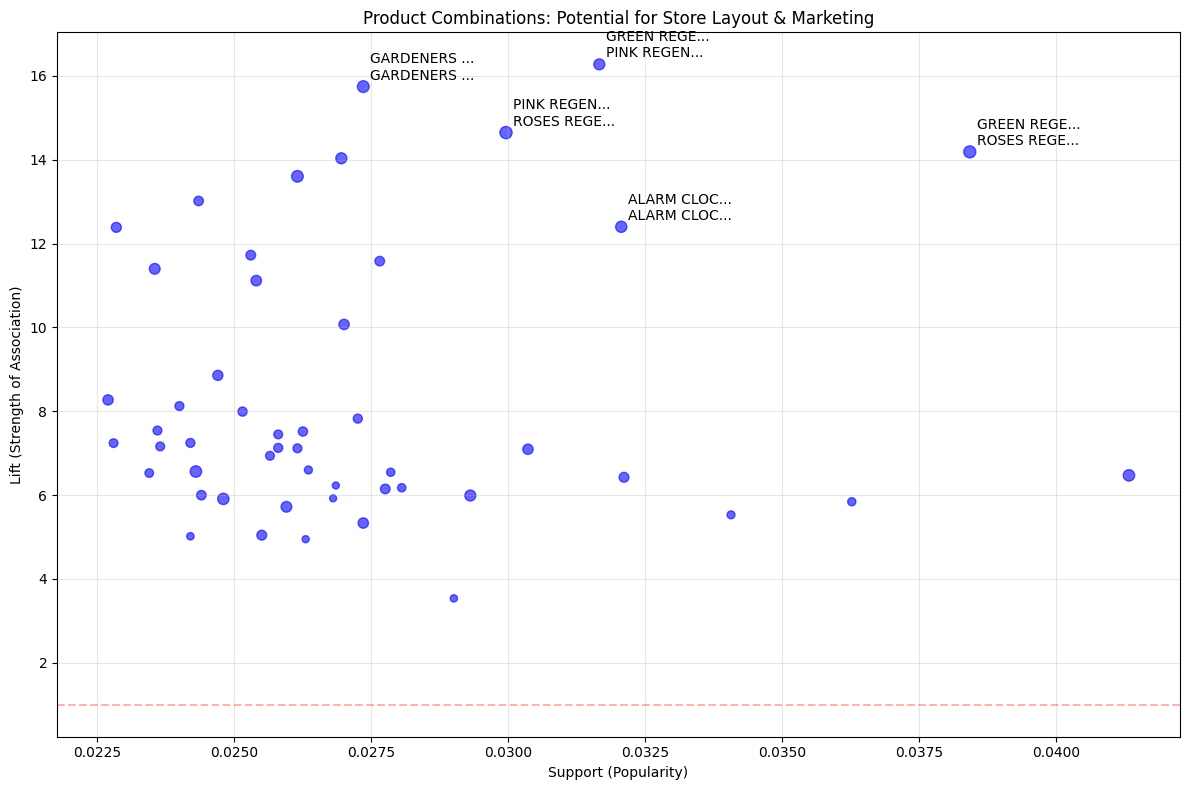

In [38]:
# Create a new DataFrame specifically for store layout and marketing insights
marketing_insights = metrics_df.copy()

# Add a new column to identify complementary products (lift > 1.5)
marketing_insights['Relationship'] = marketing_insights['Lift'].apply(
    lambda x: 'Strong Complementary' if x > 2 else 'Complementary' if x > 1 else 'Independent/Substitute')

# Add a column for practical relevance (combining support and lift)
marketing_insights['Practical_Relevance'] = marketing_insights['Support'] * marketing_insights['Lift']

# Get top combinations for store layout considerations
store_layout_recommendations = marketing_insights[marketing_insights['Lift'] > 1.2].sort_values(
    'Practical_Relevance', ascending=False).head(15)

# Display recommendations
print("\nTop Product Combinations for Store Layout Planning:")
for i, row in store_layout_recommendations.iterrows():
    print(f"{row['Item A']} + {row['Item B']}: Lift = {row['Lift']:.2f}, Support = {row['Support']:.4f}")
    
# Create visualizations for marketing insights
plt.figure(figsize=(12, 8))
plt.scatter(marketing_insights['Support'], marketing_insights['Lift'], 
            s=marketing_insights['Confidence (A→B)']*100, alpha=0.6, c='blue')

# Annotate some key points
for i, row in marketing_insights.nlargest(5, 'Practical_Relevance').iterrows():
    plt.annotate(f"{row['Item A'][:10]}...\n{row['Item B'][:10]}...", 
                 xy=(row['Support'], row['Lift']),
                 xytext=(5, 5), textcoords='offset points')

plt.title('Product Combinations: Potential for Store Layout & Marketing')
plt.xlabel('Support (Popularity)')
plt.ylabel('Lift (Strength of Association)')
plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)  # Reference line for lift=1
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##### 5.3) Which products frequently appear together in transactions?

Top 20 Product Combinations:
1. JUMBO BAG PINK POLKADOT + JUMBO BAG RED RETROSPOT: 825 times
2. GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER : 767 times
3. JUMBO BAG RED RETROSPOT + JUMBO STORAGE BAG SUKI: 724 times
4. JUMBO BAG RED RETROSPOT + JUMBO SHOPPER VINTAGE RED PAISLEY: 680 times
5. LUNCH BAG  BLACK SKULL. + LUNCH BAG RED RETROSPOT: 641 times
6. ALARM CLOCK BAKELIKE GREEN + ALARM CLOCK BAKELIKE RED : 640 times
7. GREEN REGENCY TEACUP AND SAUCER + PINK REGENCY TEACUP AND SAUCER: 632 times
8. LUNCH BAG PINK POLKADOT + LUNCH BAG RED RETROSPOT: 606 times
9. PINK REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER : 598 times
10. JUMBO  BAG BAROQUE BLACK WHITE + JUMBO BAG RED RETROSPOT: 585 times
11. JUMBO BAG RED RETROSPOT + LUNCH BAG RED RETROSPOT: 579 times
12. LUNCH BAG RED RETROSPOT + LUNCH BAG SPACEBOY DESIGN : 560 times
13. LUNCH BAG RED RETROSPOT + LUNCH BAG SUKI DESIGN : 556 times
14. LUNCH BAG CARS BLUE + LUNCH BAG RED RETROSPOT: 554 times
15.

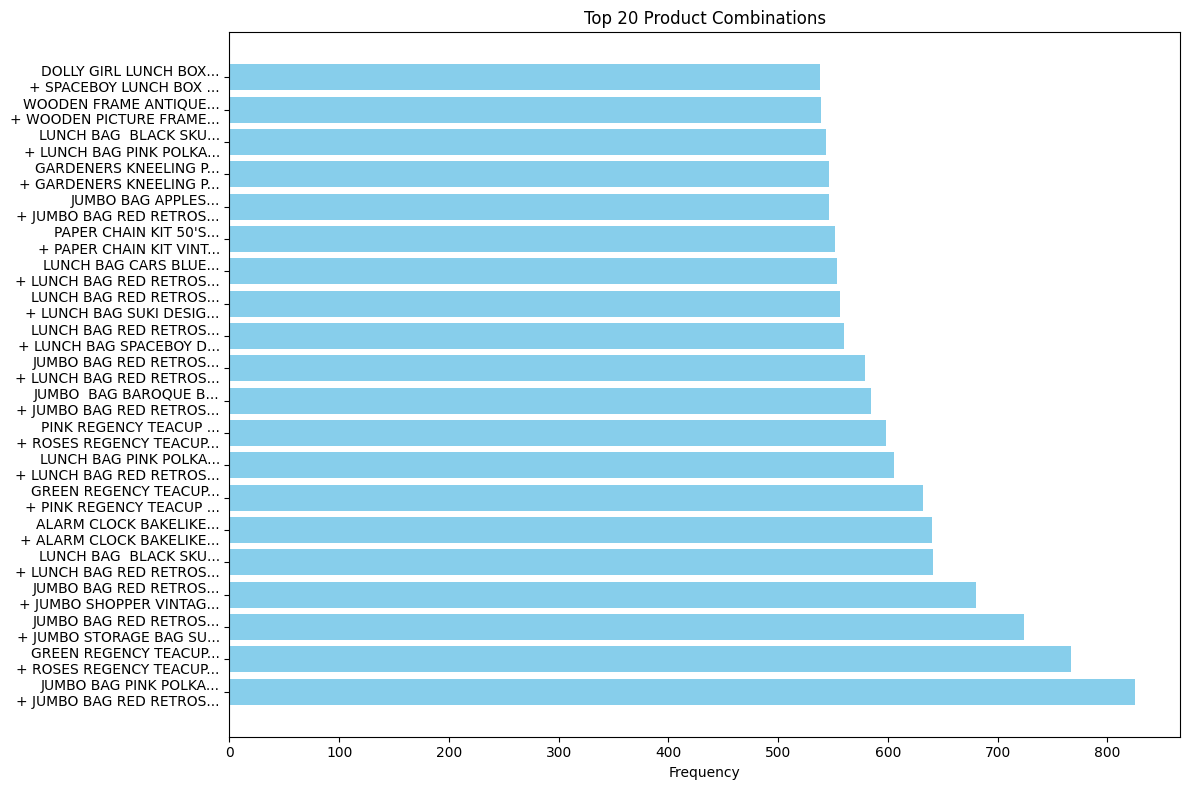

In [39]:
# Group products by invoice number
invoice_items = data.groupby('InvoiceNo')['Description'].apply(list).reset_index()

# Initialize counter for product pairs
product_pairs = Counter()

# Generate all possible pairs of products for each transaction
for items in invoice_items['Description']:
    # Only consider transactions with at least 2 items
    if len(items) >= 2:
        # Generate all possible pairs from the items in this transaction
        for pair in combinations(sorted(set(items)), 2):
            product_pairs[pair] += 1

# Get the most common product pairs
most_common_pairs = product_pairs.most_common(20)

# # Create a dataframe for better visualization
pair_df = pd.DataFrame(most_common_pairs, columns=['Product Pair', 'Frequency'])

# # Display the top product pairs
print("Top 20 Product Combinations:")
for i, (pair, count) in enumerate(most_common_pairs, 1):
    print(f"{i}. {pair[0]} + {pair[1]}: {count} times")

# # Create a bar chart to visualize the top pairs
plt.figure(figsize=(12, 8))
pair_labels = [f"{pair[0][:20]}...\n+ {pair[1][:20]}..." for pair, _ in most_common_pairs]
frequencies = [count for _, count in most_common_pairs]

plt.barh(pair_labels, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 20 Product Combinations')
plt.tight_layout()
plt.show()

### 6. Business Recommendations

##### 6.1) What cross-selling opportunities exist based on your analysis?


Top Cross-Selling Opportunities:
When customers purchase PINK REGENCY TEACUP AND SAUCER, recommend ROSES REGENCY TEACUP AND SAUCER  (Confidence: 0.78)
When customers purchase GREEN REGENCY TEACUP AND SAUCER, recommend ROSES REGENCY TEACUP AND SAUCER  (Confidence: 0.76)
When customers purchase GARDENERS KNEELING PAD CUP OF TEA , recommend GARDENERS KNEELING PAD KEEP CALM  (Confidence: 0.72)
When customers purchase CHARLOTTE BAG PINK POLKADOT, recommend RED RETROSPOT CHARLOTTE BAG (Confidence: 0.70)
When customers purchase DOTCOM POSTAGE, recommend JUMBO BAG RED RETROSPOT (Confidence: 0.69)
When customers purchase JUMBO BAG PINK POLKADOT, recommend JUMBO BAG RED RETROSPOT (Confidence: 0.68)
When customers purchase RED HANGING HEART T-LIGHT HOLDER, recommend WHITE HANGING HEART T-LIGHT HOLDER (Confidence: 0.67)
When customers purchase ALARM CLOCK BAKELIKE GREEN, recommend ALARM CLOCK BAKELIKE RED  (Confidence: 0.65)
When customers purchase DOLLY GIRL LUNCH BOX, recommend SPACEBOY LUNCH B

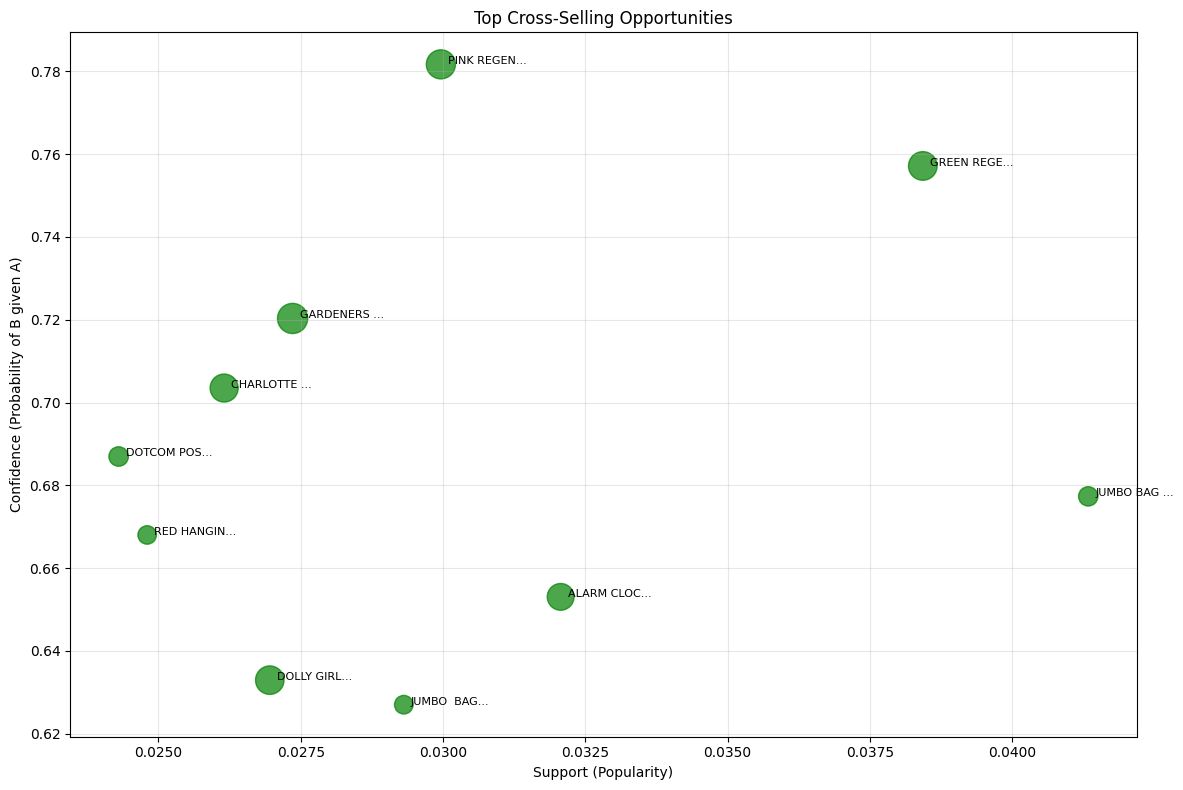

In [41]:
# Identify top cross-selling opportunities based on high confidence but manageable lift
cross_sell_opportunities = marketing_insights[
    (marketing_insights['Confidence (A→B)'] > 0.5) & 
    (marketing_insights['Support'] > 0.01)
].sort_values('Confidence (A→B)', ascending=False).head(10)

# Display cross-selling recommendations
print("\nTop Cross-Selling Opportunities:")
for i, row in cross_sell_opportunities.iterrows():
    print(f"When customers purchase {row['Item A']}, recommend {row['Item B']} (Confidence: {row['Confidence (A→B)']:.2f})")

# Visualize cross-selling opportunities
plt.figure(figsize=(12, 8))
plt.scatter(cross_sell_opportunities['Support'], cross_sell_opportunities['Confidence (A→B)'], 
            s=cross_sell_opportunities['Lift']*30, alpha=0.7, c='green')

for i, row in cross_sell_opportunities.iterrows():
    plt.annotate(f"{row['Item A'][:10]}...", 
                 xy=(row['Support'], row['Confidence (A→B)']),
                 xytext=(5, 0), textcoords='offset points', fontsize=8)
    
plt.title('Top Cross-Selling Opportunities')
plt.xlabel('Support (Popularity)')
plt.ylabel('Confidence (Probability of B given A)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [42]:
# Create a 3D scatter plot for cross-selling analysis
fig = px.scatter_3d(
    marketing_insights,
    x='Support', 
    y='Confidence (A→B)', 
    z='Lift',
    color='Practical_Relevance',
    size='Confidence (A→B)',
    hover_name='Item A',
    hover_data=['Item B', 'Relationship'],
    title='Cross-Selling Opportunity Matrix (3D)',
    color_continuous_scale='viridis',
    opacity=0.8
)

fig.update_layout(
    scene = dict(
        xaxis_title='Support (Popularity)',
        yaxis_title='Confidence (A→B)',
        zaxis_title='Lift (Association Strength)'
    ),
    height=800,
    width=1000
)

fig.show()

# First create the Recommendation_Quality column
marketing_insights['Recommendation_Quality'] = pd.cut(
    marketing_insights['Confidence (A→B)'], 
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very Poor', 'Poor', 'Moderate', 'Good', 'Excellent']
)

# Now create the parallel categories diagram
fig = px.parallel_categories(
    marketing_insights,
    dimensions=['Relationship', 'Recommendation_Quality'],
    color='Lift',
    color_continuous_scale='Viridis',
    title='Product Association Types and Quality'
)

fig.update_layout(height=600, width=900)
fig.show()

##### 6.2) How could product recommendations be improved?

In [43]:
# Analyze the existing association metrics to identify improvement areas
# Create recommendation quality tiers
metrics_df['Recommendation_Quality'] = pd.cut(
    metrics_df['Confidence (A→B)'], 
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very Poor', 'Poor', 'Moderate', 'Good', 'Excellent']
)

# Count recommendations by quality tier
quality_distribution = metrics_df['Recommendation_Quality'].value_counts().sort_index()

# Suggest improvements based on quality distribution
print("\nRecommendation Quality Distribution:")
for quality, count in quality_distribution.items():
    print(f"{quality}: {count} product pairs")

# Identify customer segments for personalized recommendations
# For example, using country data we already have
top_countries = data['Country'].value_counts().head(5).index

# For each top country, find the strongest product associations
print("\nPersonalized Recommendations by Country:")
for country in top_countries:
    country_data = data[data['Country'] == country]
    country_transactions = country_data.groupby('InvoiceNo')['Description'].apply(list).reset_index()
    
    if len(country_transactions) > 10:  # Only analyze if we have enough data
        print(f"\n{country} - Top product combinations:")
        
        # Simple approach: Find common product pairs for this country
        country_pairs = Counter()
        for items in country_transactions['Description']:
            if len(items) >= 2:
                for pair in combinations(sorted(set(items)), 2):
                    country_pairs[pair] += 1
                    
        # Show top 3 pairs for this country
        for pair, count in country_pairs.most_common(3):
            print(f"  - {pair[0]} + {pair[1]}: {count} times")


Recommendation Quality Distribution:
Very Poor: 0 product pairs
Poor: 12 product pairs
Moderate: 26 product pairs
Good: 12 product pairs
Excellent: 0 product pairs

Personalized Recommendations by Country:

United Kingdom - Top product combinations:
  - JUMBO BAG PINK POLKADOT + JUMBO BAG RED RETROSPOT: 785 times
  - GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER : 700 times
  - JUMBO BAG RED RETROSPOT + JUMBO STORAGE BAG SUKI: 698 times

Germany - Top product combinations:
  - POSTAGE + ROUND SNACK BOXES SET OF4 WOODLAND : 103 times
  - POSTAGE + ROUND SNACK BOXES SET OF 4 FRUITS : 69 times
  - ROUND SNACK BOXES SET OF 4 FRUITS  + ROUND SNACK BOXES SET OF4 WOODLAND : 60 times

France - Top product combinations:
  - POSTAGE + RABBIT NIGHT LIGHT: 65 times
  - POSTAGE + RED TOADSTOOL LED NIGHT LIGHT: 62 times
  - POSTAGE + ROUND SNACK BOXES SET OF4 WOODLAND : 58 times

EIRE - Top product combinations:
  - GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUC

##### 6.3) What pricing or bundling strategies might be effective?

In [44]:
# Identify optimal product bundles based on association metrics
bundle_candidates = marketing_insights[
    (marketing_insights['Lift'] > 1.5) & 
    (marketing_insights['Support'] > 0.005) &
    (marketing_insights['Confidence (A→B)'] > 0.3)
].sort_values('Practical_Relevance', ascending=False).head(10)

# Calculate potential bundle prices with discounts
bundle_recommendations = []
for _, row in bundle_candidates.iterrows():
    # Get average prices of products
    item_a_avg_price = data[data['Description'] == row['Item A']]['UnitPrice'].mean()
    item_b_avg_price = data[data['Description'] == row['Item B']]['UnitPrice'].mean()
    regular_price = item_a_avg_price + item_b_avg_price
    
    # Calculate different discount options
    discount_options = {
        '5%': regular_price * 0.95,
        '10%': regular_price * 0.90,
        '15%': regular_price * 0.85
    }
    
    bundle_recommendations.append({
        'Item A': row['Item A'],
        'Item B': row['Item B'],
        'Regular Price': regular_price,
        'Discount Options': discount_options,
        'Lift': row['Lift'],
        'Support': row['Support']
    })

# Display bundling recommendations
print("\nRecommended Product Bundles with Pricing Options:")
for i, bundle in enumerate(bundle_recommendations, 1):
    print(f"\nBundle {i}: {bundle['Item A']} + {bundle['Item B']}")
    print(f"Regular Price: £{bundle['Regular Price']:.2f}")
    print(f"Pricing Options:")
    for discount, price in bundle['Discount Options'].items():
        print(f"  - {discount} discount: £{price:.2f}")


Recommended Product Bundles with Pricing Options:

Bundle 1: GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER 
Regular Price: £7.47
Pricing Options:
  - 5% discount: £7.10
  - 10% discount: £6.73
  - 15% discount: £6.35

Bundle 2: GREEN REGENCY TEACUP AND SAUCER + PINK REGENCY TEACUP AND SAUCER
Regular Price: £7.50
Pricing Options:
  - 5% discount: £7.13
  - 10% discount: £6.75
  - 15% discount: £6.38

Bundle 3: PINK REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER 
Regular Price: £7.34
Pricing Options:
  - 5% discount: £6.97
  - 10% discount: £6.61
  - 15% discount: £6.24

Bundle 4: GARDENERS KNEELING PAD CUP OF TEA  + GARDENERS KNEELING PAD KEEP CALM 
Regular Price: £3.85
Pricing Options:
  - 5% discount: £3.66
  - 10% discount: £3.46
  - 15% discount: £3.27

Bundle 5: ALARM CLOCK BAKELIKE GREEN + ALARM CLOCK BAKELIKE RED 
Regular Price: £8.92
Pricing Options:
  - 5% discount: £8.48
  - 10% discount: £8.03
  - 15% discount: £7.58

Bundle 6: DOLLY GIRL LUN

In [46]:
# Create a bubble chart for bundle pricing strategies
bundle_df = pd.DataFrame([
    {
        'Item_Pair': f"{bundle['Item A'][:20]}... + {bundle['Item B'][:20]}...",
        'Regular_Price': bundle['Regular Price'],
        'Discounted_Price': bundle['Discount Options']['10%'],
        'Lift': bundle['Lift'],
        'Support': bundle['Support'],
        'Discount_Amount': bundle['Regular Price'] - bundle['Discount Options']['10%']
    }
    for bundle in bundle_recommendations[:8]  # Top 8 for readability
])

fig = px.scatter(
    bundle_df,
    x='Regular_Price',
    y='Discounted_Price',
    size='Discount_Amount',
    color='Lift',
    hover_name='Item_Pair',
    text='Item_Pair',
    title='Bundle Pricing Strategy Analysis',
    color_continuous_scale='RdYlGn',
    labels={
        'Regular_Price': 'Regular Price (£)',
        'Discounted_Price': '10% Discounted Price (£)'
    },
    size_max=40
)

# Add a diagonal line representing no discount
max_price = max(bundle_df['Regular_Price']) * 1.1
fig.add_trace(
    go.Scatter(
        x=[0, max_price],
        y=[0, max_price],
        mode='lines',
        line=dict(dash='dash', color='gray'),
        name='No Discount Line'
    )
)

fig.update_layout(
    height=600,
    width=1000,
    xaxis_range=[0, max_price],
    yaxis_range=[0, max_price]
)

fig.update_traces(
    textposition='top center',
    textfont=dict(size=10),
)

fig.show()

##### 6.4) Are there opportunities for targeted marketing campaigns?

In [47]:
# Identify product combinations with seasonal patterns for targeted campaigns
seasonal_insights = data.groupby(['Season', 'Description'])['Quantity'].sum().reset_index()
seasonal_top_products = seasonal_insights.sort_values(['Season', 'Quantity'], ascending=[True, False]).groupby('Season').head(10)

# Identify customer segments based on purchasing patterns
# For example, high-value customers
invoice_totals = data.groupby('InvoiceNo')['TotalPrice'].sum().reset_index()
high_value_invoices = invoice_totals[invoice_totals['TotalPrice'] > invoice_totals['TotalPrice'].quantile(0.9)]
high_value_transactions = data[data['InvoiceNo'].isin(high_value_invoices['InvoiceNo'])]

# Analyze high-value customer product preferences
high_value_products = high_value_transactions.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(20)

print("\nTargeted Marketing Campaign Opportunities:")
print("\n1. Seasonal Product Campaigns:")
for season, group in seasonal_top_products.groupby('Season'):
    print(f"\n{season} campaign featuring:")
    for i, (_, row) in enumerate(group.iterrows(), 1):
        if i <= 5:  # Show top 5 products per season
            print(f"  - {row['Description']}: {row['Quantity']} units")

print("\n2. High-Value Customer Campaigns:")
print("Top products for premium customer targeting:")
for product, sales in high_value_products.items():
    print(f"  - {product}: £{sales:.2f}")


Targeted Marketing Campaign Opportunities:

1. Seasonal Product Campaigns:

Fall campaign featuring:
  - POPCORN HOLDER: 22415 units
  - RABBIT NIGHT LIGHT: 21492 units
  - WORLD WAR 2 GLIDERS ASSTD DESIGNS: 16254 units
  - JUMBO BAG RED RETROSPOT: 15722 units
  - PAPER CHAIN KIT 50'S CHRISTMAS : 13443 units

Spring campaign featuring:
  - WORLD WAR 2 GLIDERS ASSTD DESIGNS: 19076 units
  - SMALL POPCORN HOLDER: 11521 units
  - JUMBO BAG RED RETROSPOT: 11357 units
  - PACK OF 72 RETROSPOT CAKE CASES: 10460 units
  - WHITE HANGING HEART T-LIGHT HOLDER: 9877 units

Summer campaign featuring:
  - JUMBO BAG RED RETROSPOT: 12312 units
  - ASSORTED COLOUR BIRD ORNAMENT: 9962 units
  - ASSORTED COLOURS SILK FAN: 8259 units
  - WORLD WAR 2 GLIDERS ASSTD DESIGNS: 8145 units
  - POPCORN HOLDER: 8129 units

Winter campaign featuring:
  - PAPER CRAFT , LITTLE BIRDIE: 80995 units
  - MEDIUM CERAMIC TOP STORAGE JAR: 74422 units
  - WHITE HANGING HEART T-LIGHT HOLDER: 12066 units
  - WORLD WAR 2 GLID

In [48]:
# Create a grouped bar chart for seasonal product trends
top_seasonal_products = []

# Get top 3 products per season for better readability
for season in seasonal_top_products['Season'].unique():
    season_data = seasonal_top_products[seasonal_top_products['Season'] == season].head(3)
    top_seasonal_products.append(season_data)

top_seasonal_df = pd.concat(top_seasonal_products)

# Truncate product names for better display
top_seasonal_df['Short_Description'] = top_seasonal_df['Description'].apply(
    lambda x: x[:25] + '...' if len(x) > 25 else x
)

fig = px.bar(
    top_seasonal_df,
    x='Season',
    y='Quantity',
    color='Short_Description',
    title='Top Products by Season (For Campaign Planning)',
    barmode='group',
    height=600,
    width=1000
)

fig.update_layout(
    xaxis_title='Season',
    yaxis_title='Quantity Sold',
    legend_title='Product',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
)

fig.show()

# Create a sunburst chart for high-value customer product preferences
high_value_df = pd.DataFrame({'Product': high_value_products.index, 'Sales': high_value_products.values})
high_value_df = high_value_df.head(10)  # Top 10 for readability
high_value_df['Category'] = 'High Value'  # Dummy category for sunburst hierarchy

fig = px.sunburst(
    high_value_df,
    path=['Category', 'Product'],
    values='Sales',
    title='High-Value Customer Product Preferences',
    color='Sales',
    color_continuous_scale='Oranges'
)

fig.update_layout(height=700, width=900)
fig.show()